### This notebook is for additional carbonate chemistry evaluations, including Puget Sound. 
#### Observation data were obtained from: https://www.ncei.noaa.gov/access/ocean-carbon-acidification-data-system/oceans/SalishCruise_DataPackage.html and
#### /ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/KEY_MODEVAL/Datasets
#### Observation-model matches are from: OA_PugetSound_CarbonateChemModelvsObsMatches20152018_v202111_qualcontrol.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict
from scipy.stats.mstats import gmean
import netCDF4 as nc
from mocsy import mocsy

fs=14
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display



%matplotlib inline

In [2]:
## Bringing in observation-model matches created in OA_PugetSound_CarbonateChemModelvsObsMatches20072024_v202111_qualcontrol_MatchbySalinity.ipynb
df1 = pd.read_csv('CarbonateChemModelvsObsMatches_2007to2010_Eval202111_MatchbySalinity.csv', index_col=0,header=0)

In [3]:
## Bringing in observation-model matches created in OA_PugetSound_CarbonateChemModelvsObsMatches20072024_v202111_qualcontrol_MatchbySalinity.ipynb
df2 = pd.read_csv('CarbonateChemModelvsObsMatches_2011to2014_Eval202111_MatchbySalinity.csv', index_col=0,header=0)

In [4]:
## Bringing in observation-model matches created in OA_PugetSound_CarbonateChemModelvsObsMatches20072024_v202111_qualcontrol_MatchbySalinity.ipynb
df3 = pd.read_csv('CarbonateChemModelvsObsMatches_2015to2016_Eval202111_MatchbySalinity.csv', index_col=0,header=0)

In [5]:
## Bringing in observation-model matches created in OA_PugetSound_CarbonateChemModelvsObsMatches20072024_v202111_qualcontrol_MatchbySalinity.ipynb
df4 = pd.read_csv('CarbonateChemModelvsObsMatches_2017to2019_Eval202111_MatchbySalinity.csv', index_col=0,header=0)

In [6]:
data=pd.concat([df1,df2,df3,df4], axis=0, join='outer')

In [7]:
data.keys()

Index(['Cruise', 'dtUTC', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG',
       'DIC_FLAG', 'Unnamed: 0', 'crid', 'ln', 'stn', 'mon', 'day', 'dic',
       'alk', 'OmegaA', 'obs_j', 'obs_i', 'Year', 'Month', 'YMO', 'j', 'i',
       'mod_dissolved_inorganic_carbon', 'mod_total_alkalinity',
       'mod_dissolved_oxygen', 'mod_votemper', 'mod_vosaline',
       'matched_salinity'],
      dtype='object')

### Calculate OmegaA for observation data

In [8]:
DIC = data['DIC (uM)'].to_numpy()
TA = data['TA (uM)'].to_numpy()
Lat = data['Lat'].to_numpy()
Lon = data['Lon'].to_numpy()
Sal = data['Sal (PSS)'].to_numpy()
Temp = data['Temp (degC)'].to_numpy()
P = data['Z'].to_numpy()

In [9]:
ones = np.zeros_like(TA) #should be np.ones_like
DIC_conv=DIC*1e-3 ## to convert from uM to mol/m3
TA_conv=TA*1e-3 ## to convert from uM to mol/m3
#Temp_insitu=gsw.t_from_CT(Sal,Temp,P)
#Sal_conv=Sal*35/35.16504


In [10]:
response_tup = mocsy.mvars(temp=Temp, sal=Sal, alk=TA_conv, dic=DIC_conv,
                       sil=0.*ones, phos=0.*ones, patm=0.*ones, depth=0.*ones, lat=0.*ones, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH_obs,pco2,fco2,co2_obs,hco3,co3,OmegaA_obs,OmegaC,BetaD,DENis,p,Tis = response_tup

data['OmegaA_obs'] = OmegaA_obs
data['pH_obs'] = pH_obs
data['co2_obs'] = co2_obs

In [11]:
## Need to mask values > 100
mymaskobs = data['OmegaA_obs'] > 100;
data['OmegaA_obs_mask'] = np.ma.array(data['OmegaA_obs'], mask=mymaskobs)

### Calculate OmegaA for model data

In [12]:
DIC_mod = data['mod_dissolved_inorganic_carbon'].to_numpy()
TA_mod = data['mod_total_alkalinity'].to_numpy()
Sal_mod = data['mod_vosaline'].to_numpy()
Temp_mod = data['mod_votemper'].to_numpy()

In [13]:
DIC_mod_conv=DIC_mod*1e-3
TA_mod_conv=TA_mod*1e-3
Temp_insitu_mod=gsw.t_from_CT(Sal_mod,Temp_mod,P)
Sal_conv_mod=Sal_mod*35/35.16504

In [14]:
response_tup = mocsy.mvars(temp=Temp_mod, sal=Sal_conv_mod, alk=TA_mod_conv, dic=DIC_mod_conv,
                       sil=0.*ones, phos=0.*ones, patm=0.*ones, depth=0.*ones, lat=0.*ones, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH_mod,pco2,fco2,co2_mod,hco3,co3,OmegaA_mod,OmegaC,BetaD,DENis,p,Tis = response_tup

data['OmegaA_mod'] = OmegaA_mod
data['pH_mod'] = pH_mod
data['co2_mod'] = co2_mod

In [15]:
## Again masking values >100
mymaskmod = data['OmegaA_mod'] > 100;
data['OmegaA_mod_mask'] = np.ma.array(data['OmegaA_mod'], mask=mymaskmod)

### Plot Observation Locations

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


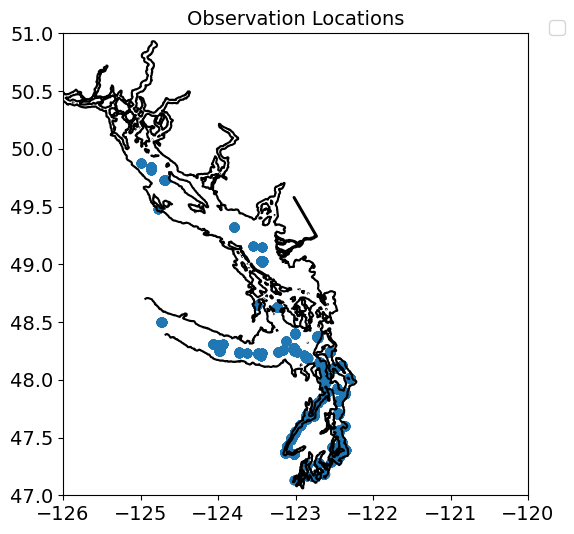

In [16]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('teal','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue')
#datreg=dict()
#for ind, iregion in enumerate(data.region_name.unique()):
#    datreg[iregion] = data.loc[data.region_name==iregion]
ax.scatter(data['Lon'], data['Lat'],marker='o') #color = colors[ind]
ax.set_ylim(47,51)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -120);
ax.set_title('Observation Locations');
ax.legend(bbox_to_anchor=(1.1, 1.05))

### Create Salish Sea subregions based on Lat/Lon data

In [17]:
## Create a column for subregions within the Salish Sea
data['broadregions']=np.nan

In [18]:
#data.loc[((data['Lat'] >= 49.1) & (data['Lat'] < 49.3) & (data['Lon'] > -123.4)),['broadregions']]='Fraser'

In [19]:
## Select data for only within the Central SoG
data.loc[((data['Lat'] >= 49.1)& (data['Lat'] < 49.5) & (data['Lon'] < -123.4) & (data['Lon'] > -124)),['broadregions']]='Central SoG'

/tmp/ipykernel_423029/424949213.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Central SoG' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[((data['Lat'] >= 49.1)& (data['Lat'] < 49.5) & (data['Lon'] < -123.4) & (data['Lon'] > -124)),['broadregions']]='Central SoG'


In [20]:
## Select data for only within the Northern SoG
data.loc[((data['Lat'] >= 49.5)& (data['Lat'] < 50) & (data['Lon'] <= -124.5) & (data['Lon'] > -125)),['broadregions']]='Northern SoG'

In [21]:
## Select data for only within the Juan de Fuca Strait
#data.loc[((data['Lat'] >= 48.0) & (data['Lat'] < 49.0) & (data['Lon'] > -123.25)),['broadregions']]='JdF'

data.loc[((data['Lat'] >= 48.2) & (data['Lat'] < 48.55) & (data['Lon'] <= -123.25) & (data['Lon'] > -124.5)),['broadregions']]='JdF'

In [22]:
## Select data for only within the Mixed region
data.loc[((data['Lat'] >= 48.3) & (data['Lat'] < 48.7) & (data['Lon'] <= -122.8) & (data['Lon'] > -123.25)),['broadregions']]='Mixed'

In [23]:
## Select data for only within Puget Sound
#data.loc[((data['Lat'] <= 48.2) & (data['Lon'] <= -122) & (data['Lon'] > -123.5)),['broadregions']]='Puget Sound'

In [24]:
data.loc[((data['Lat'] <= 48.2) & (data['Lat'] > 47.9) & (data['Lon'] <= -122.6) & (data['Lon'] > -123.5)),['broadregions']]='Admiralty Inlet'

In [25]:
data.loc[((data['Lat'] <= 48.2) & (data['Lat'] > 47.9) & (data['Lon'] > -122.6)),['broadregions']]='Whidbey Basin'

In [26]:
data.loc[((data['Lat'] <= 47.9) & (data['Lat'] > 47.35) & (data['Lon'] < -122.65)),['broadregions']]='Hood Canal'

In [27]:
data.loc[((data['Lat'] <= 47.9) & (data['Lat'] > 47.35) & (data['Lon'] > -122.5)),['broadregions']]='Central Basin'

In [28]:
data.loc[((data['Lat'] <= 47.35) & (data['Lon'] < -122.65)),['broadregions']]='South Sound'

In [29]:
data.broadregions.unique()

array(['Central Basin', 'Admiralty Inlet', 'Hood Canal', nan,
       'Whidbey Basin', 'Mixed', 'South Sound', 'JdF', 'Northern SoG',
       'Central SoG'], dtype=object)

In [30]:
data.broadregions

0       Central Basin
1       Central Basin
2       Central Basin
3       Central Basin
4       Central Basin
            ...      
1946              NaN
1947              NaN
1948    Central Basin
1949              NaN
1950    Central Basin
Name: broadregions, Length: 7778, dtype: object

In [31]:
regions = data['broadregions'].dropna().unique()

In [32]:
print(data.head())

  Cruise       dtUTC      Time      Lat       Lon      Z  Temp (degC)  \
0  TN216  2008-02-04  21:15:00  47.5967 -122.3648  1.900        7.884   
1  TN216  2008-02-04  21:15:00  47.5967 -122.3648  1.901        7.875   
2  TN216  2008-02-04  21:15:00  47.5967 -122.3648  1.902        7.878   
3  TN216  2008-02-04  21:15:00  47.5967 -122.3648  1.905        7.876   
4  TN216  2008-02-04  21:15:00  47.5967 -122.3648  1.910        7.877   

   Temp (CT degC)  Sal (g kg-1)  Sal (PSS)  ...  matched_salinity  \
0        7.962132     29.396203     29.255  ...         29.386812   
1        7.953537     29.364048     29.223  ...         29.381758   
2        7.956427     29.373092     29.232  ...         29.381758   
3        7.954383     29.375101     29.234  ...         29.381758   
4        7.955419     29.373091     29.232  ...         29.381758   

     OmegaA_obs        pH_obs       co2_obs  OmegaA_obs_mask  OmegaA_mod  \
0  1.000000e+20  1.000000e+20  1.000000e+20              NaN    1.1483

In [33]:
data.keys()

Index(['Cruise', 'dtUTC', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG',
       'DIC_FLAG', 'Unnamed: 0', 'crid', 'ln', 'stn', 'mon', 'day', 'dic',
       'alk', 'OmegaA', 'obs_j', 'obs_i', 'Year', 'Month', 'YMO', 'j', 'i',
       'mod_dissolved_inorganic_carbon', 'mod_total_alkalinity',
       'mod_dissolved_oxygen', 'mod_votemper', 'mod_vosaline',
       'matched_salinity', 'OmegaA_obs', 'pH_obs', 'co2_obs',
       'OmegaA_obs_mask', 'OmegaA_mod', 'pH_mod', 'co2_mod', 'OmegaA_mod_mask',
       'broadregions'],
      dtype='object')

In [34]:
#data=data.dropna(subset=['broadregions']) ## Remove NaN values until I figure out how to classify all subregions

In [35]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
  return np.log10(x+.001)

In [36]:
# define inverse log transform with same shift
def logt_inv(y):
    return 10**y-.001

In [37]:
from matplotlib.colors import LogNorm

In [38]:
#Puget=data.loc[data['broadregions']=='Puget Sound']
CentralSoG=data.loc[data['broadregions']=='Central SoG']
JdF=data.loc[data['broadregions']=='JdF']
Mixed=data.loc[data['broadregions']=='Mixed']
NorthernSoG=data.loc[data['broadregions']=='Northern SoG']
Fraser=data.loc[data['broadregions']=='Fraser']
Admiralty=data.loc[data['broadregions']=='Admiralty Inlet']
Whidbey=data.loc[data['broadregions']=='Whidbey Basin']
CentralBasin=data.loc[data['broadregions']=='Central Basin']
Hood=data.loc[data['broadregions']=='Hood Canal']
SouthSound=data.loc[data['broadregions']=='South Sound']


In [39]:
#Define seasons
#data['Month']=[ii.month for ii in data['dtUTC']]
DJF=data.loc[(data.Month==12)|(data.Month==1)|(data.Month==2)]
MAM=data.loc[(data.Month==3)|(data.Month==4)|(data.Month==5)]
JJA=data.loc[(data.Month==6)|(data.Month==7)|(data.Month==8)]
SON=data.loc[(data.Month==9)|(data.Month==10)|(data.Month==11)]

In [40]:
cm1=cmocean.cm.thermal
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

In [41]:
## For stats
datreg=dict()
for iregion in data.broadregions.dropna().unique():
    datreg[iregion] = data.loc[data.broadregions==iregion]   

In [42]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({'All':data,
                      'z < 25 m':data.loc[data.Z<25],
                      '25 m < z < 50 m':data.loc[(data.Z>=25)&(data.Z<50)],
                      '50 m < z < 150 m':data.loc[(data.Z>=50)&(data.Z<150)],
                      'z >= 150 m':data.loc[data.Z>=150],
                      'Winter':DJF,
                      'Spring':MAM,
                      'Summer':JJA,
                      'Autumn': SON,})
for iregion in data.broadregions.dropna().unique():
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

odict_keys(['All', 'z < 25 m', '25 m < z < 50 m', '50 m < z < 150 m', 'z >= 150 m', 'Winter', 'Spring', 'Summer', 'Autumn', 'Central Basin', 'Admiralty Inlet', 'Hood Canal', 'Whidbey Basin', 'Mixed', 'South Sound', 'JdF', 'Northern SoG', 'Central SoG'])

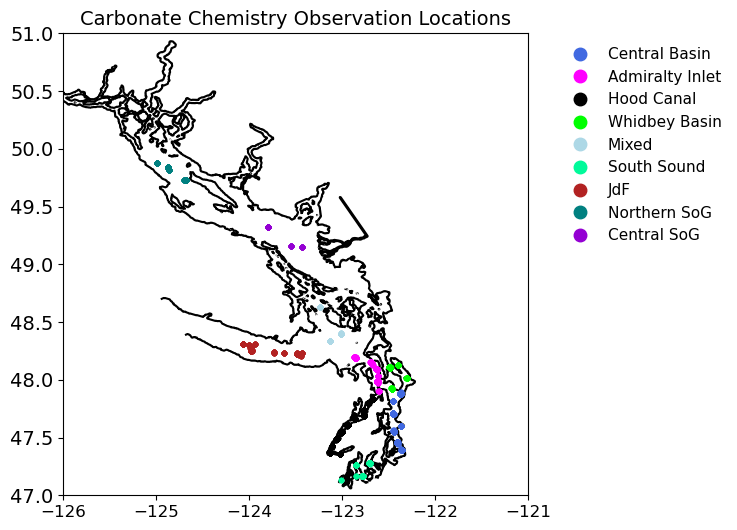

In [43]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1,color='k')
colors=('royalblue',
'fuchsia','black',
'lime','lightblue','mediumspringgreen',
'firebrick',
        'teal',

'darkviolet',
 'deepskyblue','darkgoldenrod',

'black','green','darkorange','deepskyblue','darkgreen','darkblue','slateblue','purple')
datreg=dict()
for ind, iregion in enumerate(data.broadregions.dropna().unique()):
    datreg[iregion] = data.loc[data.broadregions==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 51)
plt.yticks(fontsize=12);
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -121)
plt.xticks(fontsize=12);
ax.set_title('Carbonate Chemistry Observation Locations');
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False,markerscale=3.,fontsize=11)
#fig.savefig('SalishSeaObservationLocations.jpg',bbox_inches='tight')

### Check plot of modelled salinity vs observed salinity matched by salinity

Text(0.5, 1.0, 'Salish Sea')

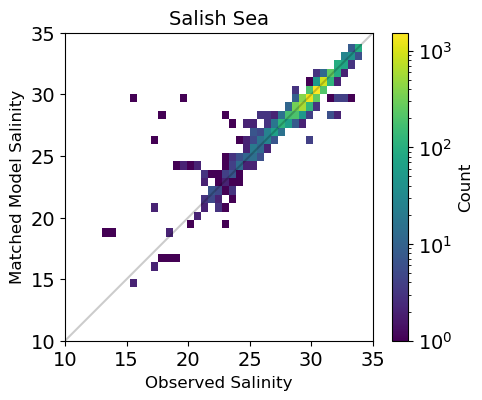

In [44]:


fig,ax=plt.subplots(1,1,figsize=(5,4))
ii=(~np.isnan(data['Sal (g kg-1)']))&(~np.isnan(data['mod_vosaline']))
counts, xedges, yedges, m1=ax.hist2d((data.loc[ii,['Sal (g kg-1)']].values.flatten()+.001),
                                      (data.loc[ii,['mod_vosaline']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((10,35),(10,35),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(10,35)
ax.set_ylim(10,35)
ax.set_aspect(1)
ax.set_ylabel('Matched Model Salinity',fontsize=12)
ax.set_xlabel('Observed Salinity',fontsize=12)
ax.set_title('Salish Sea')


In [45]:
def byDepth(ax,obsvar,modvar,lims):
    SS=et.varvarPlot(ax,data,obsvar,modvar,'Z',(25,150),'z','m',('orange','darkturquoise','navy'))
    l=ax.legend(handles=SS)
    ax.set_xlabel('Observed Salinity (g kg-1)',fontsize=12)
    ax.set_ylabel('Matched Model Salinity (g kg-1)',fontsize=12)
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return SS,l

In [46]:
def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    SS=et.varvarPlot(ax[0],DJF,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Winter')
    SS=et.varvarPlot(ax[1],MAM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Spring')
    SS=et.varvarPlot(ax[2],JJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('Summer')
    SS=et.varvarPlot(ax[3],SON,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Autumn')
    return 

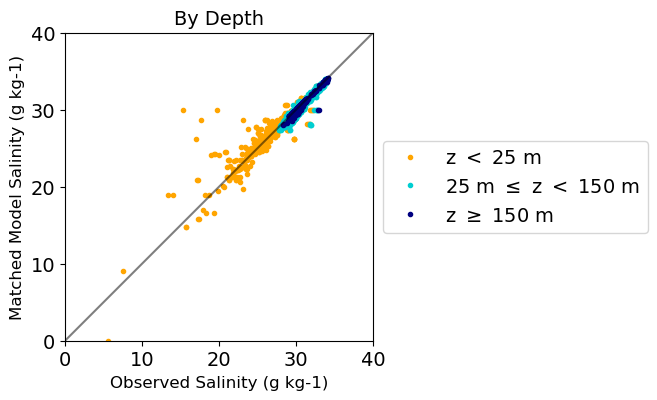

In [47]:
#obsvar=data['Salinity']
#modvar=data['mod_vosaline']

fig, ax = plt.subplots(1,1,figsize = (4,4))
SS,l=byDepth(ax,'Sal (g kg-1)','mod_vosaline',(0,40))
ax.set_title('By Depth')
ax.set_xlim(0,40)
ax.set_ylim(0,40)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

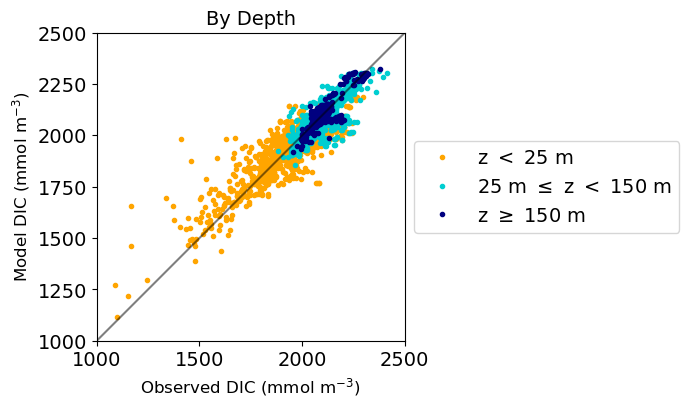

In [48]:
fig, ax = plt.subplots(1,1,figsize = (4,4))
SS,l=byDepth(ax,'DIC (uM)','mod_dissolved_inorganic_carbon',(1000,2500))
ax.set_title('By Depth')
ax.set_xlabel('Observed DIC (mmol m$^{-3}$)')
ax.set_ylabel('Model DIC (mmol m$^{-3}$)')
ax.set_xlim(1000,2500)
ax.set_ylim(1000,2500)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [62]:
(data['DIC (uM)']).max()

2414.370173886808

In [63]:
(data['mod_dissolved_inorganic_carbon']).max()

2324.35791015625

## Take a look at some evaluations for DIC, Total Alkalinity, and Aragonate Saturation:

Text(2400, 1100, 'RMSE = 59.02')

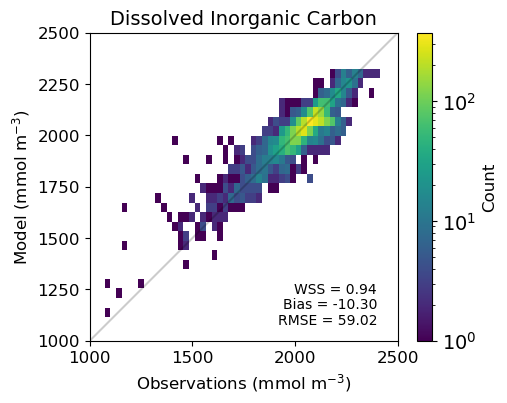

In [49]:
#DIC

fig,ax=plt.subplots(1,1,figsize=(5,4))
ii=(~np.isnan(data['DIC (uM)']))&(~np.isnan(data['mod_dissolved_inorganic_carbon']))
counts, xedges, yedges, m1=ax.hist2d((data.loc[ii,['DIC (uM)']].values.flatten()+.001),
                                      (data.loc[ii,['mod_dissolved_inorganic_carbon']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((1000,2500),(1000,2500),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(1000,2500)
ax.set_ylim(1000,2500)
plt.yticks(fontsize=12);
plt.xticks(fontsize=12);
ax.set_aspect(1)
ax.set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax.set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax.set_title('Dissolved Inorganic Carbon')

ax.text(2400, 1250, 'WSS = 0.94', fontsize=10,  color='k',horizontalalignment='right', verticalalignment='center')
ax.text(2400, 1175, 'Bias = -10.30', fontsize=10,  color='k',horizontalalignment='right', verticalalignment='center')
ax.text(2400, 1100, 'RMSE = 59.02', fontsize=10,  color='k',horizontalalignment='right', verticalalignment='center')



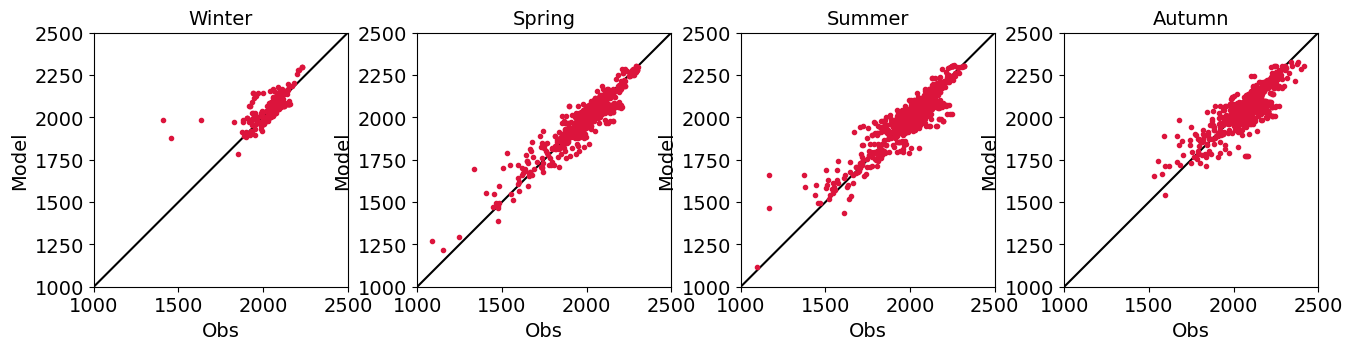

In [50]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'DIC (uM)','mod_dissolved_inorganic_carbon',(1000,2500))

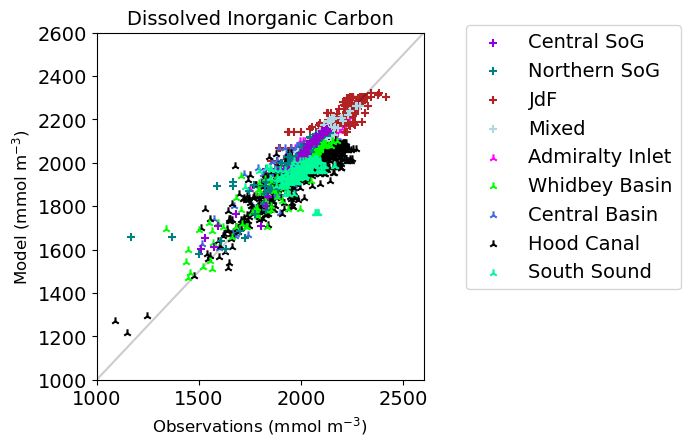

In [51]:
## DIC
fig, ax = plt.subplots(1,1,figsize = (5,5))
fig.tight_layout(pad=3)
ax.scatter((CentralSoG['DIC (uM)']),(CentralSoG['mod_dissolved_inorganic_carbon']),color='darkviolet',label='Central SoG',marker='+',zorder=10)
ax.scatter((NorthernSoG['DIC (uM)']),(NorthernSoG['mod_dissolved_inorganic_carbon']),color='teal',label='Northern SoG',marker='+',zorder=8)
ax.scatter((JdF['DIC (uM)']),(JdF['mod_dissolved_inorganic_carbon']),color='firebrick',label='JdF',marker='+',zorder=2)
ax.scatter((Mixed['DIC (uM)']),(Mixed['mod_dissolved_inorganic_carbon']),color='lightblue',label='Mixed',marker='+',zorder=6)
#ax.scatter((Puget['DIC (uM)']),(Puget['mod_dissolved_inorganic_carbon']),label='Puget',marker='+',zorder=1)
ax.scatter((Admiralty['DIC (uM)']),(Admiralty['mod_dissolved_inorganic_carbon']),color='fuchsia',label='Admiralty Inlet',marker='2',zorder=1)
ax.scatter((Whidbey['DIC (uM)']),(Whidbey['mod_dissolved_inorganic_carbon']),color='lime',label='Whidbey Basin',marker='2',zorder=6)
ax.scatter((CentralBasin['DIC (uM)']),(CentralBasin['mod_dissolved_inorganic_carbon']),color='royalblue',label='Central Basin',marker='2',zorder=2)
ax.scatter((Hood['DIC (uM)']),(Hood['mod_dissolved_inorganic_carbon']),color='black',label='Hood Canal',marker='2',zorder=4)
ax.scatter((SouthSound['DIC (uM)']),(SouthSound['mod_dissolved_inorganic_carbon']),color='mediumspringgreen',label='South Sound',marker='2',zorder=10)

ax.set_ylim(1000,2600)
ax.set_xlim(1000,2600)
ax.plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax.set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax.set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax.set_title('Dissolved Inorganic Carbon')
ax.legend(bbox_to_anchor=(1.1, 1.05))

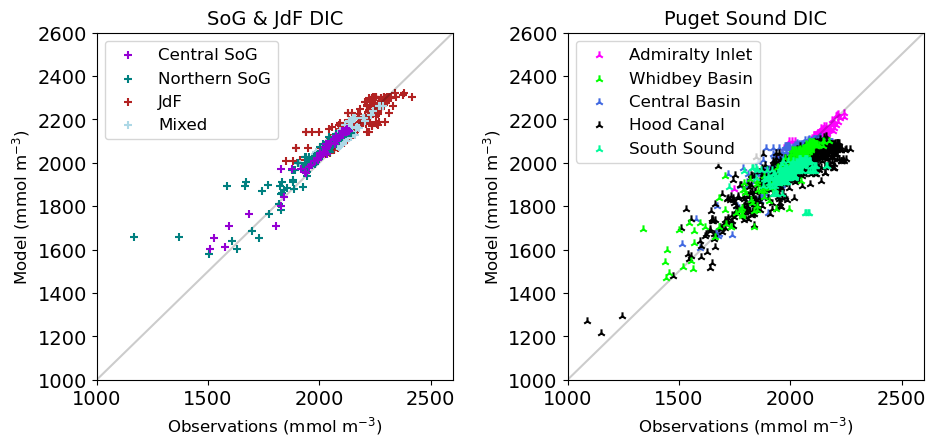

In [52]:
## DIC
fig, ax = plt.subplots(1,2,figsize = (10,5))
fig.tight_layout(pad=3)
ax[0].scatter((CentralSoG['DIC (uM)']),(CentralSoG['mod_dissolved_inorganic_carbon']),color='darkviolet',label='Central SoG',marker='+',zorder=10)
ax[0].scatter((NorthernSoG['DIC (uM)']),(NorthernSoG['mod_dissolved_inorganic_carbon']),color='teal',label='Northern SoG',marker='+',zorder=8)
ax[0].scatter((JdF['DIC (uM)']),(JdF['mod_dissolved_inorganic_carbon']),color='firebrick',label='JdF',marker='+',zorder=2)
ax[0].scatter((Mixed['DIC (uM)']),(Mixed['mod_dissolved_inorganic_carbon']),color='lightblue',label='Mixed',marker='+',zorder=6)
ax[0].set_ylim(1000,2600)
ax[0].set_xlim(1000,2600)
ax[0].plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax[0].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[0].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[0].set_title('SoG & JdF DIC')
ax[0].legend(loc=2,fontsize=12)


#ax.scatter((Puget['DIC (uM)']),(Puget['mod_dissolved_inorganic_carbon']),label='Puget',marker='+',zorder=1)
ax[1].scatter((Admiralty['DIC (uM)']),(Admiralty['mod_dissolved_inorganic_carbon']),color='fuchsia',label='Admiralty Inlet',marker='2',zorder=1)
ax[1].scatter((Whidbey['DIC (uM)']),(Whidbey['mod_dissolved_inorganic_carbon']),color='lime',label='Whidbey Basin',marker='2',zorder=6)
ax[1].scatter((CentralBasin['DIC (uM)']),(CentralBasin['mod_dissolved_inorganic_carbon']),color='royalblue',label='Central Basin',marker='2',zorder=2)
ax[1].scatter((Hood['DIC (uM)']),(Hood['mod_dissolved_inorganic_carbon']),color='black',label='Hood Canal',marker='2',zorder=4)
ax[1].scatter((SouthSound['DIC (uM)']),(SouthSound['mod_dissolved_inorganic_carbon']),color='mediumspringgreen',label='South Sound',marker='2',zorder=10)

ax[1].set_ylim(1000,2600)
ax[1].set_xlim(1000,2600)
ax[1].plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax[1].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[1].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[1].set_title('Puget Sound DIC')
ax[1].legend(loc=2,fontsize=12)

Text(0.5, 0.98, 'Dissolved Inorganic Carbon')

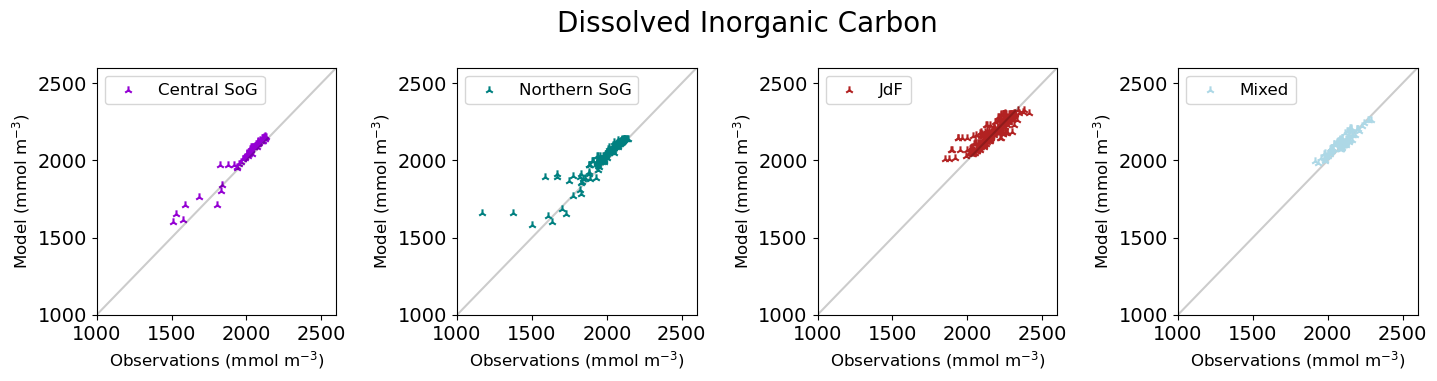

In [53]:
fig, ax = plt.subplots(1,4,figsize = (15,4))
fig.tight_layout(pad=3)

#ax.scatter((Puget['DIC (uM)']),(Puget['mod_dissolved_inorganic_carbon']),label='Puget',marker='+',zorder=1)
ax[0].scatter((CentralSoG['DIC (uM)']),(CentralSoG['mod_dissolved_inorganic_carbon']),color='darkviolet',label='Central SoG',marker='2',zorder=1)
ax[0].set_ylim(1000,2600)
ax[0].set_xlim(1000,2600)
ax[0].plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax[0].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[0].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[0].legend(loc=2,fontsize=12)

ax[1].scatter((NorthernSoG['DIC (uM)']),(NorthernSoG['mod_dissolved_inorganic_carbon']),color='teal',label='Northern SoG',marker='2',zorder=6)
ax[1].set_ylim(1000,2600)
ax[1].set_xlim(1000,2600)
ax[1].plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax[1].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[1].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[1].legend(loc=2,fontsize=12)

ax[2].scatter((JdF['DIC (uM)']),(JdF['mod_dissolved_inorganic_carbon']),color='firebrick',label='JdF',marker='2',zorder=2)
ax[2].set_ylim(1000,2600)
ax[2].set_xlim(1000,2600)
ax[2].plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax[2].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[2].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[2].legend(loc=2,fontsize=12)

ax[3].scatter((Mixed['DIC (uM)']),(Mixed['mod_dissolved_inorganic_carbon']),color='lightblue',label='Mixed',marker='2',zorder=4)
ax[3].set_ylim(1000,2600)
ax[3].set_xlim(1000,2600)
ax[3].plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax[3].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[3].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[3].legend(loc=2,fontsize=12)

fig.suptitle('Dissolved Inorganic Carbon',fontsize=20)

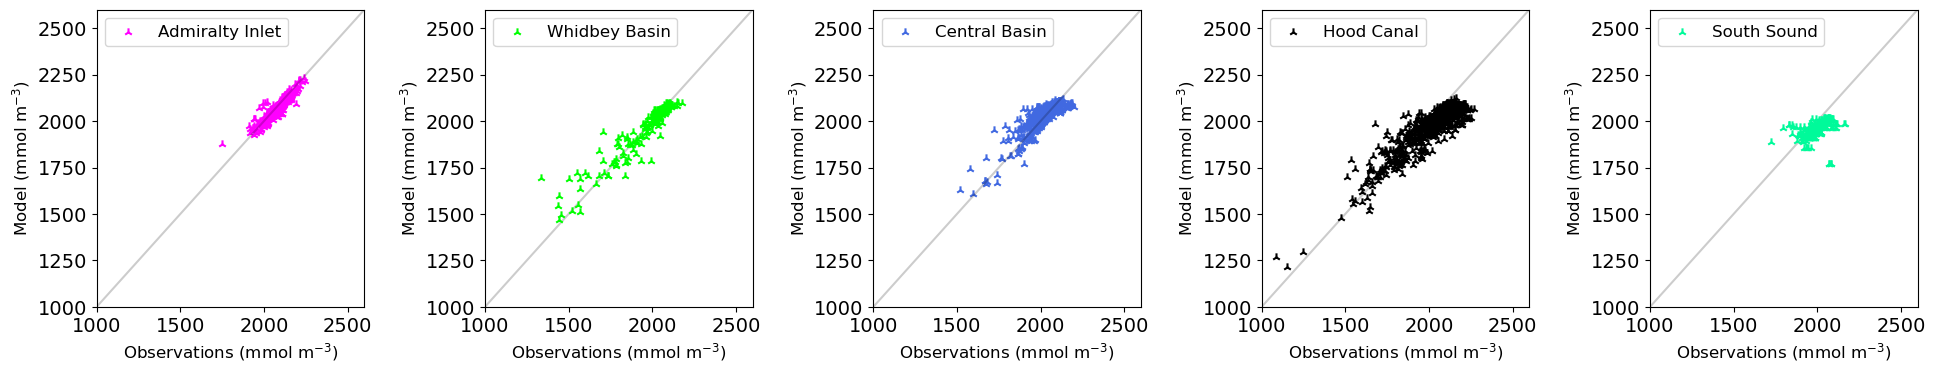

In [54]:
## DIC
fig, ax = plt.subplots(1,5,figsize = (20,4.5))
fig.tight_layout(pad=3)


#ax.scatter((Puget['DIC (uM)']),(Puget['mod_dissolved_inorganic_carbon']),label='Puget',marker='+',zorder=1)
ax[0].scatter((Admiralty['DIC (uM)']),(Admiralty['mod_dissolved_inorganic_carbon']),color='fuchsia',label='Admiralty Inlet',marker='2',zorder=1)
ax[0].set_ylim(1000,2600)
ax[0].set_xlim(1000,2600)
ax[0].plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax[0].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[0].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[0].legend(loc=2,fontsize=12)

ax[1].scatter((Whidbey['DIC (uM)']),(Whidbey['mod_dissolved_inorganic_carbon']),color='lime',label='Whidbey Basin',marker='2',zorder=6)
ax[1].set_ylim(1000,2600)
ax[1].set_xlim(1000,2600)
ax[1].plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax[1].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[1].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[1].legend(loc=2,fontsize=12)

ax[2].scatter((CentralBasin['DIC (uM)']),(CentralBasin['mod_dissolved_inorganic_carbon']),color='royalblue',label='Central Basin',marker='2',zorder=2)
ax[2].set_ylim(1000,2600)
ax[2].set_xlim(1000,2600)
ax[2].plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax[2].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[2].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[2].legend(loc=2,fontsize=12)

ax[3].scatter((Hood['DIC (uM)']),(Hood['mod_dissolved_inorganic_carbon']),color='black',label='Hood Canal',marker='2',zorder=4)
ax[3].set_ylim(1000,2600)
ax[3].set_xlim(1000,2600)
ax[3].plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax[3].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[3].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[3].legend(loc=2,fontsize=12)
#ax.scatter((SouthBasin['DIC (uM)']),(SouthBasin['mod_dissolved_inorganic_carbon']),label='South Basin',marker='2',zorder=10)


ax[4].scatter((SouthSound['DIC (uM)']),(SouthSound['mod_dissolved_inorganic_carbon']),color='mediumspringgreen',label='South Sound',marker='2',zorder=4)
ax[4].set_ylim(1000,2600)
ax[4].set_xlim(1000,2600)
ax[4].plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax[4].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[4].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[4].legend(loc=2,fontsize=12)

#fig.suptitle('Puget Sound Dissolved Inorganic Carbon',fontsize=16)

(1500.0, 2200.0)

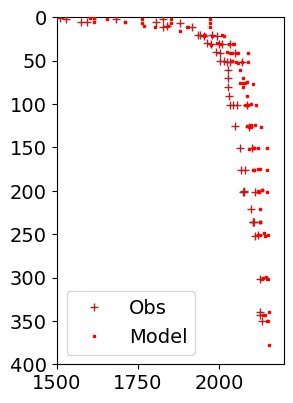

In [55]:
fig, ax = plt.subplots(1,1,figsize = (4,5))
fig.tight_layout(pad=3)
ax.plot((CentralSoG['DIC (uM)']),(CentralSoG['Z']),linestyle='',color='firebrick',label='Obs',marker='+',zorder=10)
ax.plot((CentralSoG['mod_dissolved_inorganic_carbon']),(CentralSoG['Z']),linestyle='',color='red',markersize=2,label='Model',marker='s',zorder=10)
ax.legend()
ax.set_ylim(400,0)
ax.set_xlim(1500,2200)

### Table containing evaluation statistics

In [56]:
# Defining variables needed for evaluations
obsvar='DIC (uM)'
modvar='mod_dissolved_inorganic_carbon'
year=2018

In [131]:
statsDict = {year: dict()}
statsDict[year]['DIC'] = OrderedDict()

# Loop through all subsets
for isub in statsubs:
    print(isub)
    statsDict[year]['DIC'][isub] = dict()
    var = statsDict[year]['DIC'][isub]
    
    # Get stats
    var['N'], mmean, omean, var['Bias'], var['RMSE'], var['WSS'] = et.stats(
        statsubs[isub].loc[:, [obsvar]],
        statsubs[isub].loc[:, [modvar]]
    )

# Create table and summary
tbl, tdf = et.displayStats(
    statsDict[year]['DIC'],
    level='Subset',
    suborder=list(statsubs.keys())
)

# Format numbers: 1 decimal for 'N', 2 decimals for everything else
def my_format(x, decimals):
    if pd.isna(x):
        return ""
    return f"{x:.{decimals}f}"

# Apply formatting to the Styler object (tbl)
tbl = tbl.format({
    'N': lambda x: my_format(x, 1),
    **{col: (lambda x: my_format(x, 2)) for col in tbl.columns if col != 'N'}
})


# Display final nicely formatted table
tbl

All
z < 25 m
25 m < z < 50 m
50 m < z < 150 m
z >= 150 m
Winter
Spring
Summer
Autumn
Central Basin
Admiralty Inlet
Hood Canal
Whidbey Basin
Mixed
South Sound
JdF
Northern SoG
Central SoG


Text(2300, 1500, 'RMSE = 40.87')

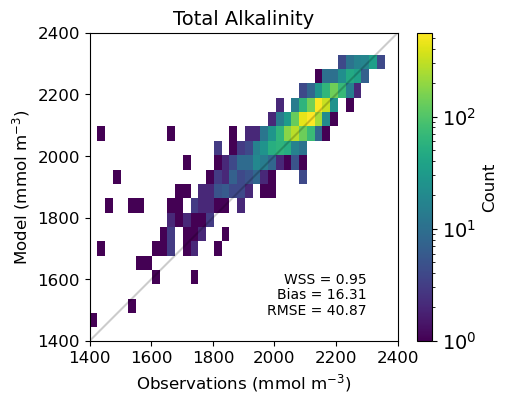

In [58]:
#Total Alkalinity

fig,ax=plt.subplots(1,1,figsize=(5,4))
ii=(~np.isnan(data['TA (uM)']))&(~np.isnan(data['mod_total_alkalinity']))
counts, xedges, yedges, m1=ax.hist2d(((data.loc[ii,['TA (uM)']].values.flatten()+.001)),
                                      (data.loc[ii,['mod_total_alkalinity']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((1400,2400),(1400,2400),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(1400,2400)
ax.set_ylim(1400,2400)
plt.yticks(fontsize=12);
plt.xticks(fontsize=12);
ax.set_aspect(1)
ax.set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax.set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax.set_title('Total Alkalinity')
ax.text(2300, 1600, 'WSS = 0.95', fontsize=10,  color='k',horizontalalignment='right', verticalalignment='center')
ax.text(2300, 1550, 'Bias = 16.31', fontsize=10,  color='k',horizontalalignment='right', verticalalignment='center')
ax.text(2300, 1500, 'RMSE = 40.87', fontsize=10,  color='k',horizontalalignment='right', verticalalignment='center')

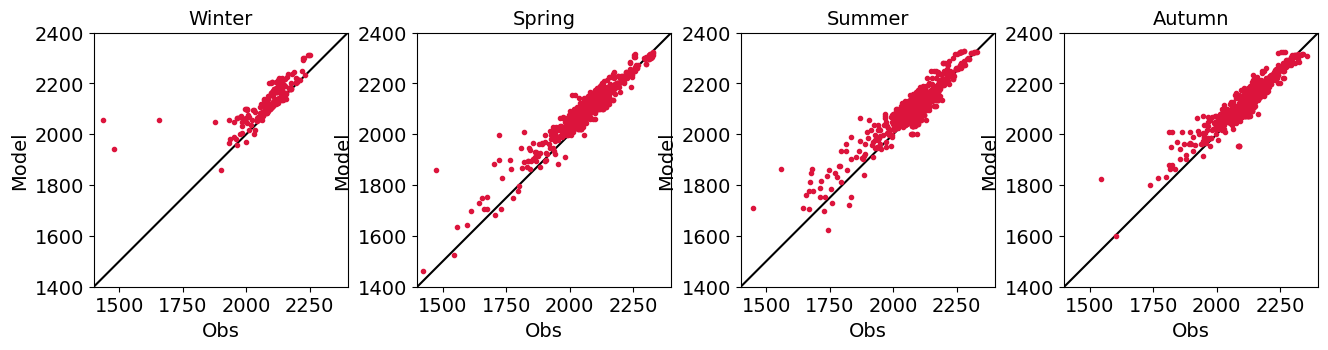

In [59]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'TA (uM)','mod_total_alkalinity',(1400,2400))

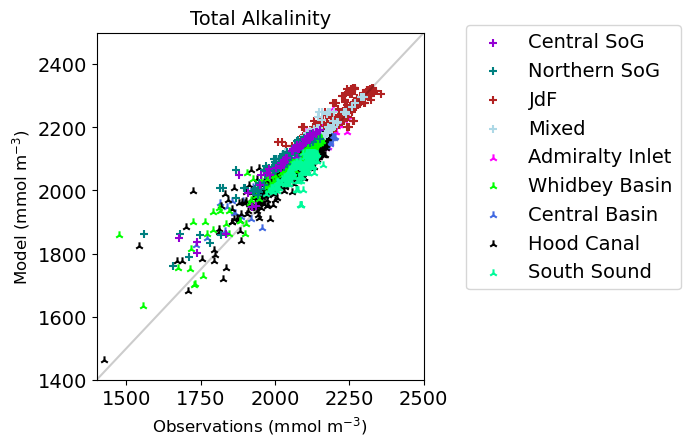

In [60]:
## Total Alkalinity

fig, ax = plt.subplots(1,1,figsize = (5,5))
fig.tight_layout(pad=3)
ax.scatter((CentralSoG['TA (uM)']),(CentralSoG['mod_total_alkalinity']),color='darkviolet',label='Central SoG',marker='+',zorder=10)
ax.scatter((NorthernSoG['TA (uM)']),(NorthernSoG['mod_total_alkalinity']),color='teal',label='Northern SoG',marker='+',zorder=8)
ax.scatter((JdF['TA (uM)']),(JdF['mod_total_alkalinity']),color='firebrick',label='JdF',marker='+',zorder=2)
ax.scatter((Mixed['TA (uM)']),(Mixed['mod_total_alkalinity']),color='lightblue',label='Mixed',marker='+',zorder=6)
#ax.scatter((Puget['TA (uM)']),(Puget['mod_total_alkalinity']),label='Puget',marker='+',zorder=1)
ax.scatter((Admiralty['TA (uM)']),(Admiralty['mod_total_alkalinity']),color='fuchsia',label='Admiralty Inlet',marker='2',zorder=1)
ax.scatter((Whidbey['TA (uM)']),(Whidbey['mod_total_alkalinity']),color='lime',label='Whidbey Basin',marker='2',zorder=6)
ax.scatter((CentralBasin['TA (uM)']),(CentralBasin['mod_total_alkalinity']),color='royalblue',label='Central Basin',marker='2',zorder=2)
ax.scatter((Hood['TA (uM)']),(Hood['mod_total_alkalinity']),color='black',label='Hood Canal',marker='2',zorder=4)
ax.scatter((SouthSound['TA (uM)']),(SouthSound['mod_total_alkalinity']),color='mediumspringgreen',label='South Sound',marker='2',zorder=10)


ax.set_ylim(1400,2500)
ax.set_xlim(1400,2500)
ax.plot((1400,2500),(1400,2500),'k-',alpha=.2)
ax.set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax.set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax.set_title('Total Alkalinity')
ax.legend(bbox_to_anchor=(1.1, 1.05))

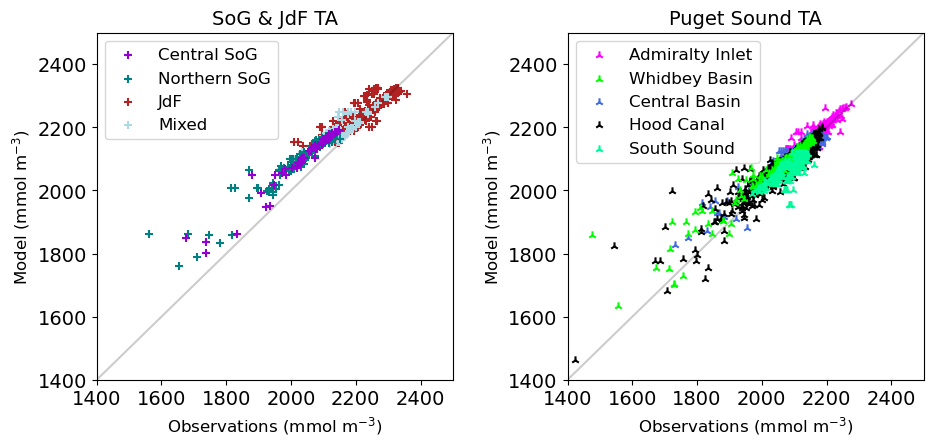

In [61]:
## TA
fig, ax = plt.subplots(1,2,figsize = (10,5))
fig.tight_layout(pad=3)
ax[0].scatter((CentralSoG['TA (uM)']),(CentralSoG['mod_total_alkalinity']),color='darkviolet',label='Central SoG',marker='+',zorder=10)
ax[0].scatter((NorthernSoG['TA (uM)']),(NorthernSoG['mod_total_alkalinity']),color='teal',label='Northern SoG',marker='+',zorder=8)
ax[0].scatter((JdF['TA (uM)']),(JdF['mod_total_alkalinity']),color='firebrick',label='JdF',marker='+',zorder=2)
ax[0].scatter((Mixed['TA (uM)']),(Mixed['mod_total_alkalinity']),color='lightblue',label='Mixed',marker='+',zorder=6)
ax[0].set_ylim(1400,2500)
ax[0].set_xlim(1400,2500)
ax[0].plot((1400,2500),(1400,2500),'k-',alpha=.2)
ax[0].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[0].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[0].set_title('SoG & JdF TA')
ax[0].legend(loc=2,fontsize=12)


#ax.scatter((Puget['DIC (uM)']),(Puget['mod_dissolved_inorganic_carbon']),label='Puget',marker='+',zorder=1)
ax[1].scatter((Admiralty['TA (uM)']),(Admiralty['mod_total_alkalinity']),color='fuchsia',label='Admiralty Inlet',marker='2',zorder=1)
ax[1].scatter((Whidbey['TA (uM)']),(Whidbey['mod_total_alkalinity']),color='lime',label='Whidbey Basin',marker='2',zorder=6)
ax[1].scatter((CentralBasin['TA (uM)']),(CentralBasin['mod_total_alkalinity']),color='royalblue',label='Central Basin',marker='2',zorder=2)
ax[1].scatter((Hood['TA (uM)']),(Hood['mod_total_alkalinity']),color='black',label='Hood Canal',marker='2',zorder=4)
ax[1].scatter((SouthSound['TA (uM)']),(SouthSound['mod_total_alkalinity']),color='mediumspringgreen',label='South Sound',marker='2',zorder=10)

ax[1].set_ylim(1400,2500)
ax[1].set_xlim(1400,2500)
ax[1].plot((1400,2500),(1400,2500),'k-',alpha=.2)
ax[1].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[1].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[1].set_title('Puget Sound TA')
ax[1].legend(loc=2,fontsize=12)

Text(0.5, 0.98, 'Total Alkalinity')

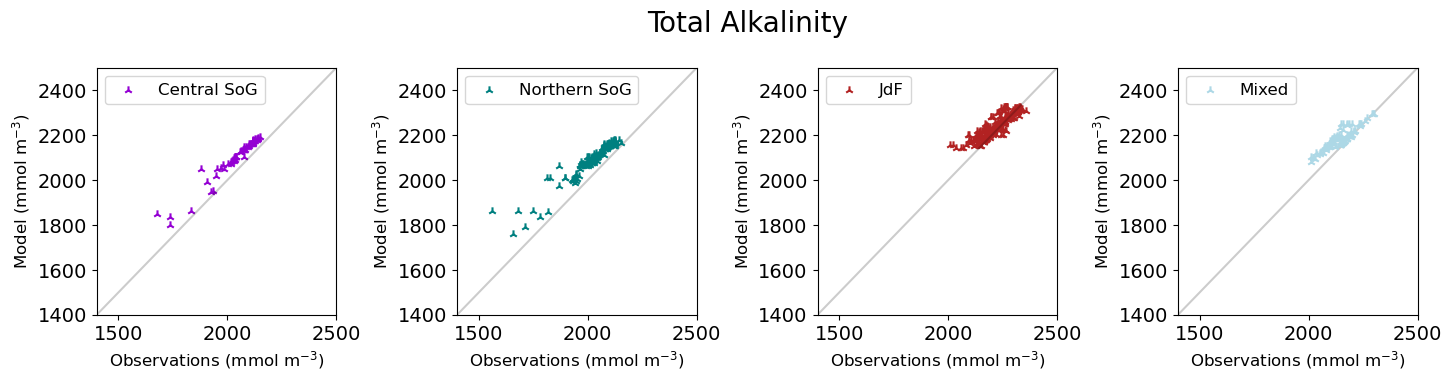

In [108]:
## TA
fig, ax = plt.subplots(1,4,figsize = (15,4))
fig.tight_layout(pad=3)

#ax.scatter((Puget['DIC (uM)']),(Puget['mod_dissolved_inorganic_carbon']),label='Puget',marker='+',zorder=1)
ax[0].scatter((CentralSoG['TA (uM)']),(CentralSoG['mod_total_alkalinity']),color='darkviolet',label='Central SoG',marker='2',zorder=1)
ax[0].set_ylim(1400,2500)
ax[0].set_xlim(1400,2500)
ax[0].plot((1400,2500),(1400,2500),'k-',alpha=.2)
ax[0].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[0].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[0].legend(loc=2,fontsize=12)

ax[1].scatter((NorthernSoG['TA (uM)']),(NorthernSoG['mod_total_alkalinity']),color='teal',label='Northern SoG',marker='2',zorder=6)
ax[1].set_ylim(1400,2500)
ax[1].set_xlim(1400,2500)
ax[1].plot((1400,2500),(1400,2500),'k-',alpha=.2)
ax[1].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[1].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[1].legend(loc=2,fontsize=12)

ax[2].scatter((JdF['TA (uM)']),(JdF['mod_total_alkalinity']),color='firebrick',label='JdF',marker='2',zorder=2)
ax[2].set_ylim(1400,2500)
ax[2].set_xlim(1400,2500)
ax[2].plot((1400,2500),(1400,2500),'k-',alpha=.2)
ax[2].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[2].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[2].legend(loc=2,fontsize=12)

ax[3].scatter((Mixed['TA (uM)']),(Mixed['mod_total_alkalinity']),color='lightblue',label='Mixed',marker='2',zorder=4)
ax[3].set_ylim(1400,2500)
ax[3].set_xlim(1400,2500)
ax[3].plot((1400,2500),(1400,2500),'k-',alpha=.2)
ax[3].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[3].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[3].legend(loc=2,fontsize=12)
#ax.scatter((SouthBasin['DIC (uM)']),(SouthBasin['mod_dissolved_inorganic_carbon']),label='South Basin',marker='2',zorder=10)
fig.suptitle('Total Alkalinity',fontsize=20)

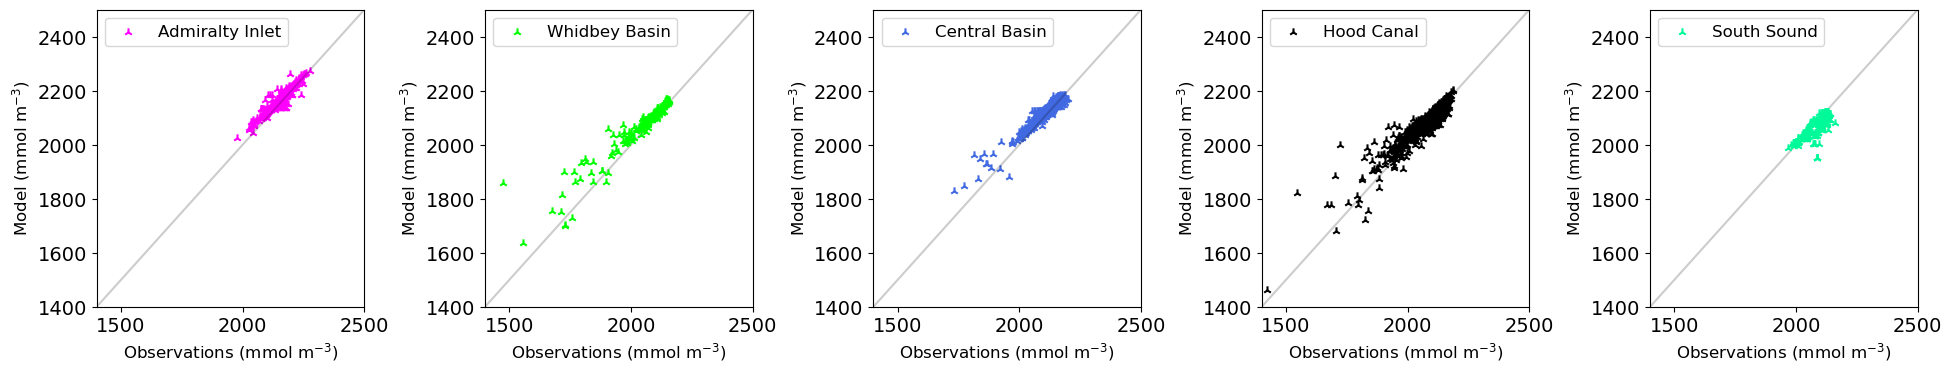

In [107]:
## TA
fig, ax = plt.subplots(1,5,figsize = (20,4.5))
fig.tight_layout(pad=3)


#ax.scatter((Puget['DIC (uM)']),(Puget['mod_dissolved_inorganic_carbon']),label='Puget',marker='+',zorder=1)
ax[0].scatter((Admiralty['TA (uM)']),(Admiralty['mod_total_alkalinity']),color='fuchsia',label='Admiralty Inlet',marker='2',zorder=1)
ax[0].set_ylim(1400,2500)
ax[0].set_xlim(1400,2500)
ax[0].plot((1400,2500),(1400,2500),'k-',alpha=.2)
ax[0].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[0].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[0].legend(loc=2,fontsize=12)

ax[1].scatter((Whidbey['TA (uM)']),(Whidbey['mod_total_alkalinity']),color='lime',label='Whidbey Basin',marker='2',zorder=6)
ax[1].set_ylim(1400,2500)
ax[1].set_xlim(1400,2500)
ax[1].plot((1400,2500),(1400,2500),'k-',alpha=.2)
ax[1].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[1].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[1].legend(loc=2,fontsize=12)

ax[2].scatter((CentralBasin['TA (uM)']),(CentralBasin['mod_total_alkalinity']),color='royalblue',label='Central Basin',marker='2',zorder=2)
ax[2].set_ylim(1400,2500)
ax[2].set_xlim(1400,2500)
ax[2].plot((1400,2500),(1400,2500),'k-',alpha=.2)
ax[2].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[2].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[2].legend(loc=2,fontsize=12)

ax[3].scatter((Hood['TA (uM)']),(Hood['mod_total_alkalinity']),color='black',label='Hood Canal',marker='2',zorder=4)
ax[3].set_ylim(1400,2500)
ax[3].set_xlim(1400,2500)
ax[3].plot((1400,2500),(1400,2500),'k-',alpha=.2)
ax[3].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[3].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[3].legend(loc=2,fontsize=12)
#ax.scatter((SouthBasin['DIC (uM)']),(SouthBasin['mod_dissolved_inorganic_carbon']),label='South Basin',marker='2',zorder=10)

ax[4].scatter((SouthSound['TA (uM)']),(SouthSound['mod_total_alkalinity']),color='mediumspringgreen',label='South Sound',marker='2',zorder=4)
ax[4].set_ylim(1400,2500)
ax[4].set_xlim(1400,2500)
ax[4].plot((1400,2500),(1400,2500),'k-',alpha=.2)
ax[4].set_xlabel('Observations (mmol m$^{-3}$)',fontsize=12)
ax[4].set_ylabel('Model (mmol m$^{-3}$)',fontsize=12)
ax[4].legend(loc=2,fontsize=12)

### Table containing evaluation statistics

In [64]:
# Defining variables needed for evaluations
obsvar2='TA (uM)'
modvar2='mod_total_alkalinity'
year=2018

In [127]:
statsDict = {year: dict()}
statsDict[year]['TA'] = OrderedDict()

# Loop through all subsets
for isub in statsubs:
    print(isub)
    statsDict[year]['TA'][isub] = dict()
    var = statsDict[year]['TA'][isub]
    
    # Get stats
    var['N'], mmean, omean, var['Bias'], var['RMSE'], var['WSS'] = et.stats(
        statsubs[isub].loc[:, [obsvar2]],
        statsubs[isub].loc[:, [modvar2]]
    )

# Create table and summary
tbl, tdf = et.displayStats(
    statsDict[year]['TA'],
    level='Subset',
    suborder=list(statsubs.keys())
)

# Format numbers: 1 decimal for 'N', 2 decimals for everything else
def my_format(x, decimals):
    if pd.isna(x):
        return ""
    return f"{x:.{decimals}f}"

# Apply formatting to the Styler object (tbl)
tbl = tbl.format({
    'N': lambda x: my_format(x, 1),
    **{col: (lambda x: my_format(x, 2)) for col in tbl.columns if col != 'N'}
})


# Display final nicely formatted table
tbl

All
z < 25 m
25 m < z < 50 m
50 m < z < 150 m
z >= 150 m
Winter
Spring
Summer
Autumn
Central Basin
Admiralty Inlet
Hood Canal
Whidbey Basin
Mixed
South Sound
JdF
Northern SoG
Central SoG


Text(3.75, 0.2, 'RMSE = 0.35')

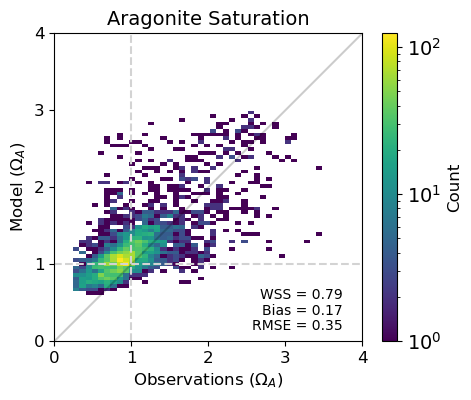

In [66]:
#OmegaA

fig,ax=plt.subplots(1,1,figsize=(5,4))
ii=(~np.isnan(data['OmegaA_obs_mask']))&(~np.isnan(data['OmegaA_mod_mask']))
counts, xedges, yedges, m1=ax.hist2d((data.loc[ii,['OmegaA_obs_mask']].values.flatten()+.001),
                                      (data.loc[ii,['OmegaA_mod_mask']].values.flatten()+.001),bins=25*2,norm=LogNorm())


ax.plot((0,4),(0,4),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
plt.yticks(fontsize=12);
plt.xticks(fontsize=12);
ax.set_aspect(1)
ax.set_ylabel('Model ($\Omega_{{A}}$)',fontsize=12)
ax.set_xlabel('Observations ($\Omega_{{A}}$)',fontsize=12)
ax.set_title('Aragonite Saturation')
ax.axvline(x=1,color='lightgrey',linestyle='--')
ax.axhline(y=1,color='lightgrey',linestyle='--')
ax.text(3.75, 0.60, 'WSS = 0.79', fontsize=10,  color='k',horizontalalignment='right', verticalalignment='center')
ax.text(3.75, 0.40, 'Bias = 0.17', fontsize=10,  color='k',horizontalalignment='right', verticalalignment='center')
ax.text(3.75, 0.20, 'RMSE = 0.35', fontsize=10,  color='k',horizontalalignment='right', verticalalignment='center')

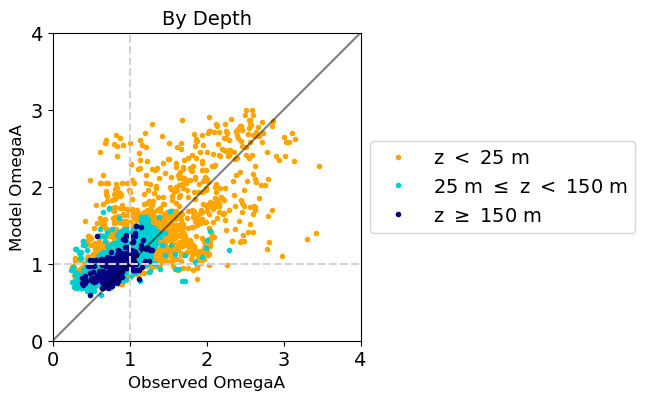

In [67]:
fig, ax = plt.subplots(1,1,figsize = (4,4))
SS,l=byDepth(ax,'OmegaA_obs_mask','OmegaA_mod_mask',(0,4))
ax.set_title('By Depth')
ax.set_xlabel('Observed OmegaA')
ax.set_ylabel('Model OmegaA')
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.axvline(x=1,color='lightgrey',linestyle='--')
ax.axhline(y=1,color='lightgrey',linestyle='--')

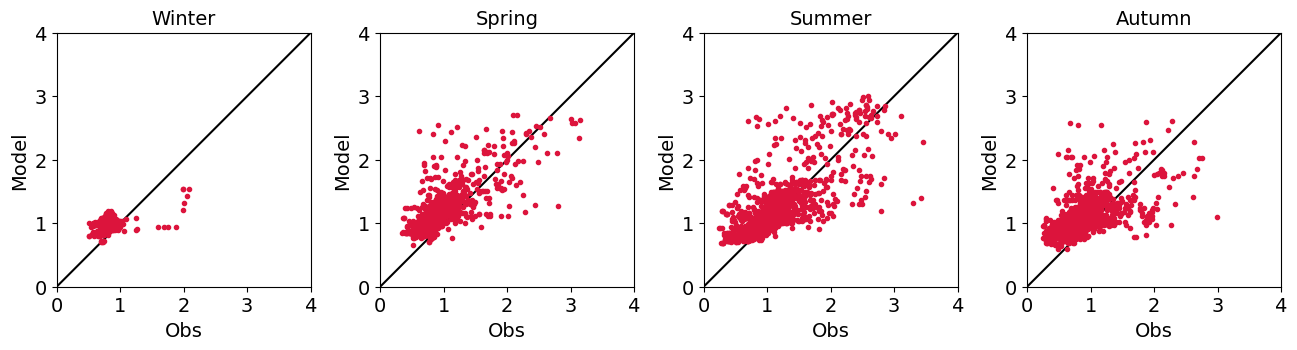

In [68]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'OmegaA_obs_mask','OmegaA_mod_mask',(0,4))

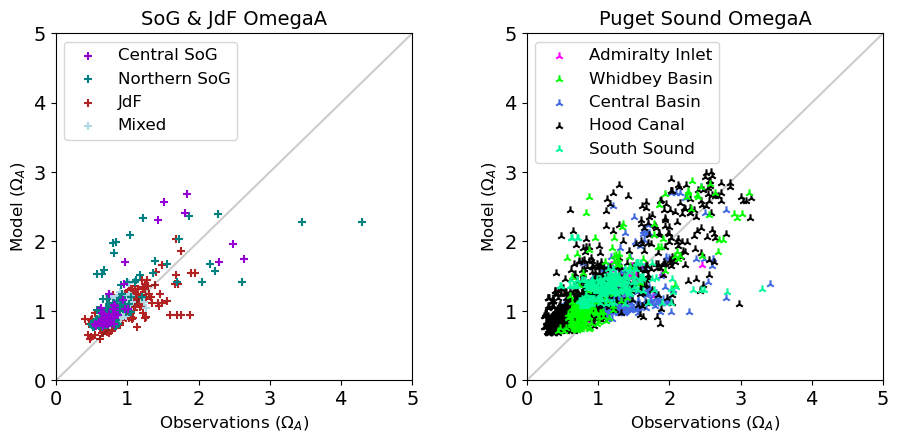

In [109]:
## OmegaA
fig, ax = plt.subplots(1,2,figsize = (10,5))
fig.tight_layout(pad=3)
ax[0].scatter((CentralSoG['OmegaA_obs_mask']),(CentralSoG['OmegaA_mod_mask']),color='darkviolet',label='Central SoG',marker='+',zorder=10)
ax[0].scatter((NorthernSoG['OmegaA_obs_mask']),(NorthernSoG['OmegaA_mod_mask']),color='teal',label='Northern SoG',marker='+',zorder=8)
ax[0].scatter((JdF['OmegaA_obs_mask']),(JdF['OmegaA_mod_mask']),color='firebrick',label='JdF',marker='+',zorder=2)
ax[0].scatter((Mixed['OmegaA_obs_mask']),(Mixed['OmegaA_mod_mask']),color='lightblue',label='Mixed',marker='+',zorder=6)
ax[0].set_ylim(0,5)
ax[0].set_xlim(0,5)
ax[0].plot((0,5),(0,5),'k-',alpha=.2)
ax[0].set_xlabel('Observations ($\Omega_{{A}}$)',fontsize=12)
ax[0].set_ylabel('Model ($\Omega_{{A}}$)',fontsize=12)
ax[0].set_title('SoG & JdF OmegaA')
ax[0].legend(loc=2,fontsize=12)


#ax.scatter((Puget['DIC (uM)']),(Puget['mod_dissolved_inorganic_carbon']),label='Puget',marker='+',zorder=1)
ax[1].scatter((Admiralty['OmegaA_obs_mask']),(Admiralty['OmegaA_mod_mask']),color='fuchsia',label='Admiralty Inlet',marker='2',zorder=1)
ax[1].scatter((Whidbey['OmegaA_obs_mask']),(Whidbey['OmegaA_mod_mask']),color='lime',label='Whidbey Basin',marker='2',zorder=6)
ax[1].scatter((CentralBasin['OmegaA_obs_mask']),(CentralBasin['OmegaA_mod_mask']),color='royalblue',label='Central Basin',marker='2',zorder=2)
ax[1].scatter((Hood['OmegaA_obs_mask']),(Hood['OmegaA_mod_mask']),color='black',label='Hood Canal',marker='2',zorder=4)
ax[1].scatter((SouthSound['OmegaA_obs_mask']),(SouthSound['OmegaA_mod_mask']),color='mediumspringgreen',label='South Sound',marker='2',zorder=10)

ax[1].set_ylim(0,5)
ax[1].set_xlim(0,5)
ax[1].plot((0,5),(0,5),'k-',alpha=.2)
ax[1].set_xlabel('Observations ($\Omega_{{A}}$)',fontsize=12)
ax[1].set_ylabel('Model ($\Omega_{{A}}$)',fontsize=12)
ax[1].set_title('Puget Sound OmegaA')
ax[1].legend(loc=2,fontsize=12)

Text(0.5, 0.98, 'Aragonite Saturation')

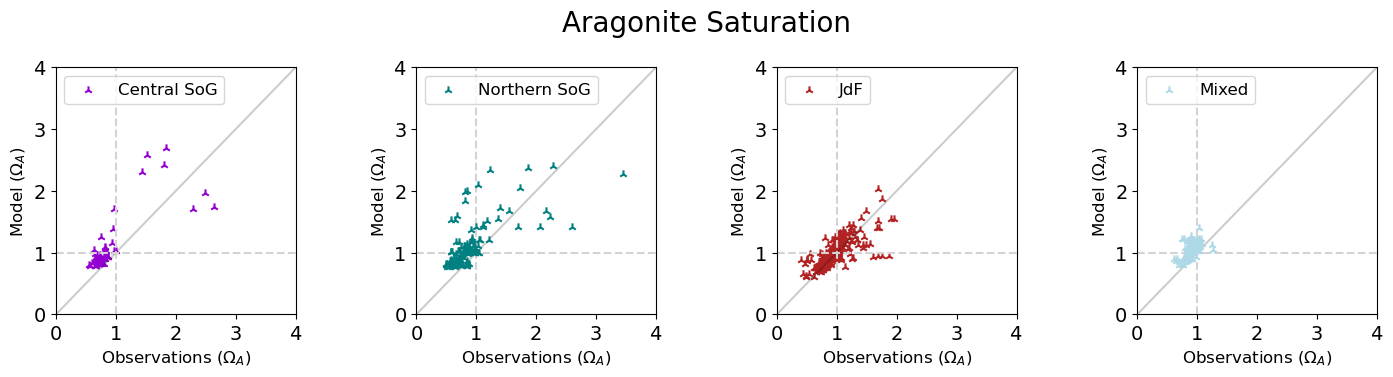

In [110]:
## Omega A
fig, ax = plt.subplots(1,4,figsize = (15,4))
fig.tight_layout(pad=3)

#ax.scatter((Puget['DIC (uM)']),(Puget['mod_dissolved_inorganic_carbon']),label='Puget',marker='+',zorder=1)
ax[0].scatter((CentralSoG['OmegaA_obs_mask']),(CentralSoG['OmegaA_mod_mask']),color='darkviolet',label='Central SoG',marker='2',zorder=1)
ax[0].set_ylim(0,4)
ax[0].set_xlim(0,4)
ax[0].plot((0,4),(0,4),'k-',alpha=.2)
ax[0].set_xlabel('Observations ($\Omega_{{A}}$)',fontsize=12)
ax[0].set_ylabel('Model ($\Omega_{{A}}$)',fontsize=12)
ax[0].legend(loc=2,fontsize=12)
ax[0].axvline(x=1,color='lightgrey',linestyle='--')
ax[0].axhline(y=1,color='lightgrey',linestyle='--')

ax[1].scatter((NorthernSoG['OmegaA_obs_mask']),(NorthernSoG['OmegaA_mod_mask']),color='teal',label='Northern SoG',marker='2',zorder=6)
ax[1].set_ylim(0,4)
ax[1].set_xlim(0,4)
ax[1].plot((0,4),(0,4),'k-',alpha=.2)
ax[1].set_xlabel('Observations ($\Omega_{{A}}$)',fontsize=12)
ax[1].set_ylabel('Model ($\Omega_{{A}}$)',fontsize=12)
ax[1].legend(loc=2,fontsize=12)
ax[1].axvline(x=1,color='lightgrey',linestyle='--')
ax[1].axhline(y=1,color='lightgrey',linestyle='--')

ax[2].scatter((JdF['OmegaA_obs_mask']),(JdF['OmegaA_mod_mask']),color='firebrick',label='JdF',marker='2',zorder=2)
ax[2].set_ylim(0,4)
ax[2].set_xlim(0,4)
ax[2].plot((0,4),(0,4),'k-',alpha=.2)
ax[2].set_xlabel('Observations ($\Omega_{{A}}$)',fontsize=12)
ax[2].set_ylabel('Model ($\Omega_{{A}}$)',fontsize=12)
ax[2].legend(loc=2,fontsize=12)
ax[2].axvline(x=1,color='lightgrey',linestyle='--')
ax[2].axhline(y=1,color='lightgrey',linestyle='--')

ax[3].scatter((Mixed['OmegaA_obs_mask']),(Mixed['OmegaA_mod_mask']),color='lightblue',label='Mixed',marker='2',zorder=4)
ax[3].set_ylim(0,4)
ax[3].set_xlim(0,4)
ax[3].plot((0,4),(0,4),'k-',alpha=.2)
ax[3].set_xlabel('Observations ($\Omega_{{A}}$)',fontsize=12)
ax[3].set_ylabel('Model ($\Omega_{{A}}$)',fontsize=12)
ax[3].legend(loc=2,fontsize=12)
ax[3].axvline(x=1,color='lightgrey',linestyle='--')
ax[3].axhline(y=1,color='lightgrey',linestyle='--')
#ax.scatter((SouthBasin['DIC (uM)']),(SouthBasin['mod_dissolved_inorganic_carbon']),label='South Basin',marker='2',zorder=10)
fig.suptitle('Aragonite Saturation',fontsize=20)

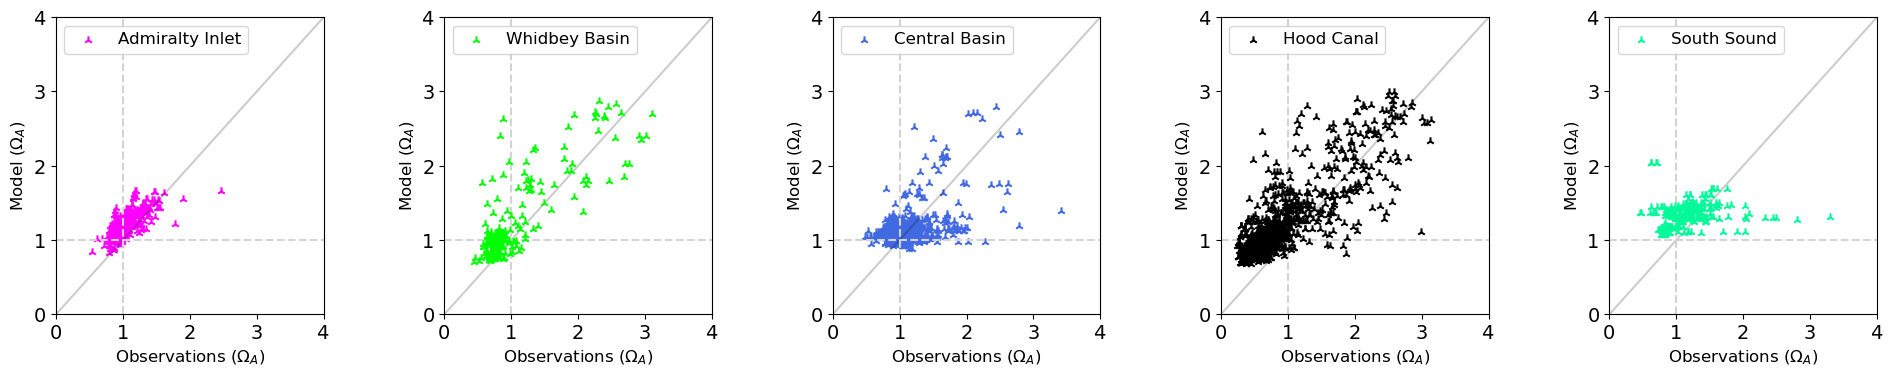

In [111]:
## OmegaA
fig, ax = plt.subplots(1,5,figsize = (20,4.5))
fig.tight_layout(pad=3)



ax[0].scatter((Admiralty['OmegaA_obs_mask']),(Admiralty['OmegaA_mod_mask']),color='fuchsia',label='Admiralty Inlet',marker='2',zorder=1)
ax[0].set_ylim(0,4)
ax[0].set_xlim(0,4)
ax[0].plot((0,4),(0,4),'k-',alpha=.2)
ax[0].set_xlabel('Observations ($\Omega_{{A}}$)',fontsize=12)
ax[0].set_ylabel('Model ($\Omega_{{A}}$)',fontsize=12)
ax[0].legend(loc=2,fontsize=12)
ax[0].axvline(x=1,color='lightgrey',linestyle='--')
ax[0].axhline(y=1,color='lightgrey',linestyle='--')

ax[1].scatter((Whidbey['OmegaA_obs_mask']),(Whidbey['OmegaA_mod_mask']),color='lime',label='Whidbey Basin',marker='2',zorder=6)
ax[1].set_ylim(0,4)
ax[1].set_xlim(0,4)
ax[1].plot((0,4),(0,4),'k-',alpha=.2)
ax[1].set_xlabel('Observations ($\Omega_{{A}}$)',fontsize=12)
ax[1].set_ylabel('Model ($\Omega_{{A}}$)',fontsize=12)
ax[1].legend(loc=2,fontsize=12)
ax[1].axvline(x=1,color='lightgrey',linestyle='--')
ax[1].axhline(y=1,color='lightgrey',linestyle='--')

ax[2].scatter((CentralBasin['OmegaA_obs_mask']),(CentralBasin['OmegaA_mod_mask']),color='royalblue',label='Central Basin',marker='2',zorder=2)
ax[2].set_ylim(0,4)
ax[2].set_xlim(0,4)
ax[2].plot((0,4),(0,4),'k-',alpha=.2)
ax[2].set_xlabel('Observations ($\Omega_{{A}}$)',fontsize=12)
ax[2].set_ylabel('Model ($\Omega_{{A}}$)',fontsize=12)
ax[2].legend(loc=2,fontsize=12)
ax[2].axvline(x=1,color='lightgrey',linestyle='--')
ax[2].axhline(y=1,color='lightgrey',linestyle='--')

ax[3].scatter((Hood['OmegaA_obs_mask']),(Hood['OmegaA_mod_mask']),color='black',label='Hood Canal',marker='2',zorder=4)
ax[3].set_ylim(0,4)
ax[3].set_xlim(0,4)
ax[3].plot((0,4),(0,4),'k-',alpha=.2)
ax[3].set_xlabel('Observations ($\Omega_{{A}}$)',fontsize=12)
ax[3].set_ylabel('Model ($\Omega_{{A}}$)',fontsize=12)
ax[3].legend(loc=2,fontsize=12)
ax[3].axvline(x=1,color='lightgrey',linestyle='--')
ax[3].axhline(y=1,color='lightgrey',linestyle='--')
#ax.scatter((SouthBasin['DIC (uM)']),(SouthBasin['mod_dissolved_inorganic_carbon']),label='South Basin',marker='2',zorder=10)

ax[4].scatter((SouthSound['OmegaA_obs_mask']),(SouthSound['OmegaA_mod_mask']),color='mediumspringgreen',label='South Sound',marker='2',zorder=4)
ax[4].set_ylim(0,4)
ax[4].set_xlim(0,4)
ax[4].plot((0,4),(0,4),'k-',alpha=.2)
ax[4].set_xlabel('Observations ($\Omega_{{A}}$)',fontsize=12)
ax[4].set_ylabel('Model ($\Omega_{{A}}$)',fontsize=12)
ax[4].legend(loc=2,fontsize=12)
ax[4].axvline(x=1,color='lightgrey',linestyle='--')
ax[4].axhline(y=1,color='lightgrey',linestyle='--')

### Table containing evaluation statistics

In [72]:
# Defining variables needed for evaluations
obsvar3='OmegaA_obs_mask'
modvar3='OmegaA_mod_mask'
year=2018

In [126]:
statsDict = {year: dict()}
statsDict[year]['OmegaA'] = OrderedDict()

# Loop through all subsets
for isub in statsubs:
    print(isub)
    statsDict[year]['OmegaA'][isub] = dict()
    var = statsDict[year]['OmegaA'][isub]
    
    # Get stats
    var['N'], mmean, omean, var['Bias'], var['RMSE'], var['WSS'] = et.stats(
        statsubs[isub].loc[:, [obsvar3]],
        statsubs[isub].loc[:, [modvar3]]
    )

# Create table and summary
tbl, tdf = et.displayStats(
    statsDict[year]['OmegaA'],
    level='Subset',
    suborder=list(statsubs.keys())
)

# Format numbers: 1 decimal for 'N', 2 decimals for everything else
def my_format(x, decimals):
    if pd.isna(x):
        return ""
    return f"{x:.{decimals}f}"

# Apply formatting to the Styler object (tbl)
tbl = tbl.format({
    'N': lambda x: my_format(x, 1),
    **{col: (lambda x: my_format(x, 2)) for col in tbl.columns if col != 'N'}
})


# Display final nicely formatted table
tbl

All
z < 25 m
25 m < z < 50 m
50 m < z < 150 m
z >= 150 m
Winter
Spring
Summer
Autumn
Central Basin
Admiralty Inlet
Hood Canal
Whidbey Basin
Mixed
South Sound
JdF
Northern SoG
Central SoG


In [118]:
print(tbl.columns)

MultiIndex([('', 'Bias'),
            ('',    'N'),
            ('', 'RMSE'),
            ('',  'WSS')],
           )


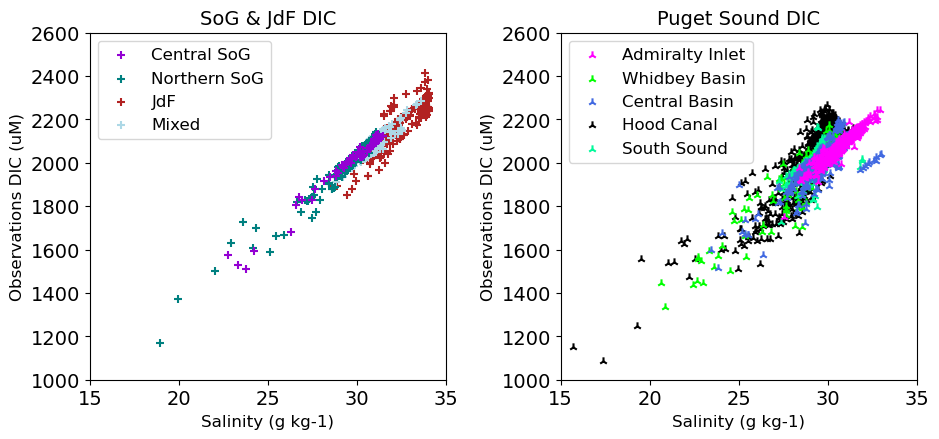

In [74]:
## DIC
fig, ax = plt.subplots(1,2,figsize = (10,5))
fig.tight_layout(pad=3)
ax[0].scatter((CentralSoG['Sal (g kg-1)']),(CentralSoG['DIC (uM)']),color='darkviolet',label='Central SoG',marker='+',zorder=10)
ax[0].scatter((NorthernSoG['Sal (g kg-1)']),(NorthernSoG['DIC (uM)']),color='teal',label='Northern SoG',marker='+',zorder=8)
ax[0].scatter((JdF['Sal (g kg-1)']),(JdF['DIC (uM)']),color='firebrick',label='JdF',marker='+',zorder=2)
ax[0].scatter((Mixed['Sal (g kg-1)']),(Mixed['DIC (uM)']),color='lightblue',label='Mixed',marker='+',zorder=6)
ax[0].set_ylim(1000,2600)
ax[0].set_xlim(15,35)
ax[0].plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax[0].set_xlabel('Salinity (g kg-1)',fontsize=12)
ax[0].set_ylabel('Observations DIC (uM)',fontsize=12)
ax[0].set_title('SoG & JdF DIC')
ax[0].legend(loc=2,fontsize=12)


#ax.scatter((Puget['DIC (uM)']),(Puget['mod_dissolved_inorganic_carbon']),label='Puget',marker='+',zorder=1)
ax[1].scatter((Admiralty['Sal (g kg-1)']),(Admiralty['DIC (uM)']),color='fuchsia',label='Admiralty Inlet',marker='2',zorder=15)
ax[1].scatter((Whidbey['Sal (g kg-1)']),(Whidbey['DIC (uM)']),color='lime',label='Whidbey Basin',marker='2',zorder=6)
ax[1].scatter((CentralBasin['Sal (g kg-1)']),(CentralBasin['DIC (uM)']),color='royalblue',label='Central Basin',marker='2',zorder=12)
ax[1].scatter((Hood['Sal (g kg-1)']),(Hood['DIC (uM)']),color='black',label='Hood Canal',marker='2',zorder=4)
ax[1].scatter((SouthSound['Sal (g kg-1)']),(SouthSound['DIC (uM)']),color='mediumspringgreen',label='South Sound',marker='2',zorder=10)

ax[1].set_ylim(1000,2600)
ax[1].set_xlim(15,35)
#ax[1].plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax[1].set_xlabel('Salinity (g kg-1)',fontsize=12)
ax[1].set_ylabel('Observations DIC (uM)',fontsize=12)
ax[1].set_title('Puget Sound DIC')
ax[1].legend(loc=2,fontsize=12)

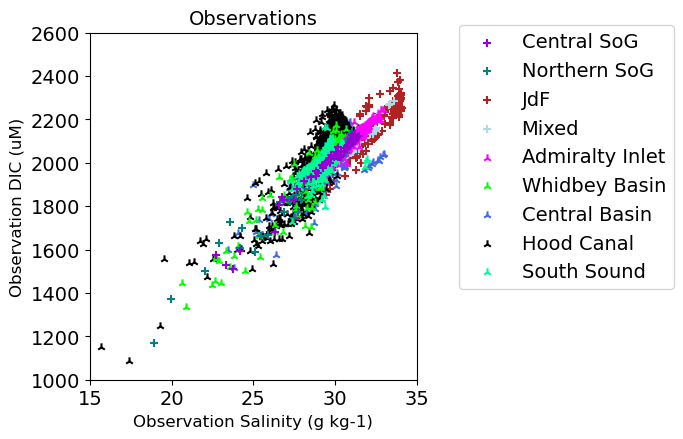

In [75]:
## DIC
fig, ax = plt.subplots(1,1,figsize = (5,5))
fig.tight_layout(pad=3)
ax.scatter((CentralSoG['Sal (g kg-1)']),(CentralSoG['DIC (uM)']),color='darkviolet',label='Central SoG',marker='+',zorder=16)
ax.scatter((NorthernSoG['Sal (g kg-1)']),(NorthernSoG['DIC (uM)']),color='teal',label='Northern SoG',marker='+',zorder=8)
ax.scatter((JdF['Sal (g kg-1)']),(JdF['DIC (uM)']),color='firebrick',label='JdF',marker='+',zorder=2)
ax.scatter((Mixed['Sal (g kg-1)']),(Mixed['DIC (uM)']),color='lightblue',label='Mixed',marker='+',zorder=6)
#ax.scatter((Puget['DIC (uM)']),(Puget['mod_dissolved_inorganic_carbon']),label='Puget',marker='+',zorder=1)
ax.scatter((Admiralty['Sal (g kg-1)']),(Admiralty['DIC (uM)']),color='fuchsia',label='Admiralty Inlet',marker='2',zorder=7)
ax.scatter((Whidbey['Sal (g kg-1)']),(Whidbey['DIC (uM)']),color='lime',label='Whidbey Basin',marker='2',zorder=6)
ax.scatter((CentralBasin['Sal (g kg-1)']),(CentralBasin['DIC (uM)']),color='royalblue',label='Central Basin',marker='2',zorder=2)
ax.scatter((Hood['Sal (g kg-1)']),(Hood['DIC (uM)']),color='black',label='Hood Canal',marker='2',zorder=4)
ax.scatter((SouthSound['Sal (g kg-1)']),(SouthSound['DIC (uM)']),color='mediumspringgreen',label='South Sound',marker='2',zorder=10)

ax.set_ylim(1000,2600)
ax.set_xlim(15,35)
#ax.plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax.set_xlabel('Observation Salinity (g kg-1)',fontsize=12)
ax.set_ylabel('Observation DIC (uM)',fontsize=12)
ax.set_title('Observations')
ax.legend(bbox_to_anchor=(1.1, 1.05))

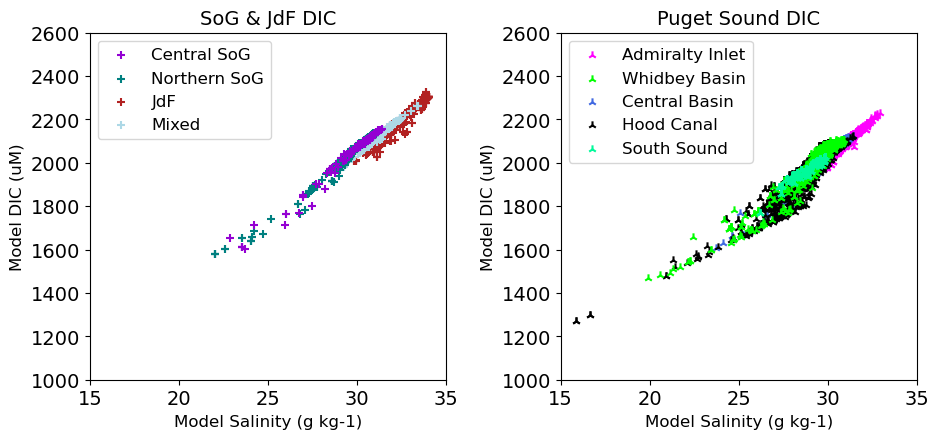

In [76]:
## DIC
fig, ax = plt.subplots(1,2,figsize = (10,5))
fig.tight_layout(pad=3)
ax[0].scatter((CentralSoG['mod_vosaline']),(CentralSoG['mod_dissolved_inorganic_carbon']),color='darkviolet',label='Central SoG',marker='+',zorder=10)
ax[0].scatter((NorthernSoG['mod_vosaline']),(NorthernSoG['mod_dissolved_inorganic_carbon']),color='teal',label='Northern SoG',marker='+',zorder=8)
ax[0].scatter((JdF['mod_vosaline']),(JdF['mod_dissolved_inorganic_carbon']),color='firebrick',label='JdF',marker='+',zorder=2)
ax[0].scatter((Mixed['mod_vosaline']),(Mixed['mod_dissolved_inorganic_carbon']),color='lightblue',label='Mixed',marker='+',zorder=6)
ax[0].set_ylim(1000,2600)
ax[0].set_xlim(15,35)
ax[0].plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax[0].set_xlabel('Model Salinity (g kg-1)',fontsize=12)
ax[0].set_ylabel('Model DIC (uM)',fontsize=12)
ax[0].set_title('SoG & JdF DIC')
ax[0].legend(loc=2,fontsize=12)


#ax.scatter((Puget['DIC (uM)']),(Puget['mod_dissolved_inorganic_carbon']),label='Puget',marker='+',zorder=1)
ax[1].scatter((Admiralty['mod_vosaline']),(Admiralty['mod_dissolved_inorganic_carbon']),color='fuchsia',label='Admiralty Inlet',marker='2',zorder=1)
ax[1].scatter((Whidbey['mod_vosaline']),(Whidbey['mod_dissolved_inorganic_carbon']),color='lime',label='Whidbey Basin',marker='2',zorder=6)
ax[1].scatter((CentralBasin['mod_vosaline']),(CentralBasin['mod_dissolved_inorganic_carbon']),color='royalblue',label='Central Basin',marker='2',zorder=2)
ax[1].scatter((Hood['mod_vosaline']),(Hood['mod_dissolved_inorganic_carbon']),color='black',label='Hood Canal',marker='2',zorder=4)
ax[1].scatter((SouthSound['mod_vosaline']),(SouthSound['mod_dissolved_inorganic_carbon']),color='mediumspringgreen',label='South Sound',marker='2',zorder=10)

ax[1].set_ylim(1000,2600)
ax[1].set_xlim(15,35)
#ax[1].plot((1000,2600),(1000,2600),'k-',alpha=.2)
ax[1].set_xlabel('Model Salinity (g kg-1)',fontsize=12)
ax[1].set_ylabel('Model DIC (uM)',fontsize=12)
ax[1].set_title('Puget Sound DIC')
ax[1].legend(loc=2,fontsize=12)

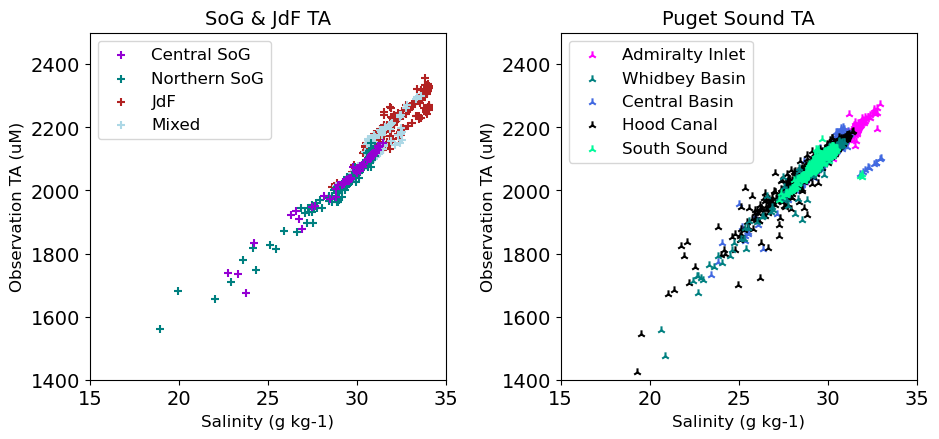

In [77]:
## TA
fig, ax = plt.subplots(1,2,figsize = (10,5))
fig.tight_layout(pad=3)
ax[0].scatter((CentralSoG['Sal (g kg-1)']),(CentralSoG['TA (uM)']),color='darkviolet',label='Central SoG',marker='+',zorder=10)
ax[0].scatter((NorthernSoG['Sal (g kg-1)']),(NorthernSoG['TA (uM)']),color='teal',label='Northern SoG',marker='+',zorder=8)
ax[0].scatter((JdF['Sal (g kg-1)']),(JdF['TA (uM)']),color='firebrick',label='JdF',marker='+',zorder=2)
ax[0].scatter((Mixed['Sal (g kg-1)']),(Mixed['TA (uM)']),color='lightblue',label='Mixed',marker='+',zorder=6)
ax[0].set_ylim(1400,2500)
ax[0].set_xlim(15,35)
#ax[0].plot((1400,2500),(1400,2500),'k-',alpha=.2)
ax[0].set_xlabel('Salinity (g kg-1)',fontsize=12)
ax[0].set_ylabel('Observation TA (uM)',fontsize=12)
ax[0].set_title('SoG & JdF TA')
ax[0].legend(loc=2,fontsize=12)


#ax.scatter((Puget['DIC (uM)']),(Puget['mod_dissolved_inorganic_carbon']),label='Puget',marker='+',zorder=1)
ax[1].scatter((Admiralty['Sal (g kg-1)']),(Admiralty['TA (uM)']),color='fuchsia',label='Admiralty Inlet',marker='2',zorder=1)
ax[1].scatter((Whidbey['Sal (g kg-1)']),(Whidbey['TA (uM)']),color='teal',label='Whidbey Basin',marker='2',zorder=6)
ax[1].scatter((CentralBasin['Sal (g kg-1)']),(CentralBasin['TA (uM)']),color='royalblue',label='Central Basin',marker='2',zorder=2)
ax[1].scatter((Hood['Sal (g kg-1)']),(Hood['TA (uM)']),color='black',label='Hood Canal',marker='2',zorder=4)
ax[1].scatter((SouthSound['Sal (g kg-1)']),(SouthSound['TA (uM)']),color='mediumspringgreen',label='South Sound',marker='2',zorder=10)

ax[1].set_ylim(1400,2500)
ax[1].set_xlim(15,35)
#ax[1].plot((1400,2500),(1400,2500),'k-',alpha=.2)
ax[1].set_xlabel('Salinity (g kg-1)',fontsize=12)
ax[1].set_ylabel('Observation TA (uM)',fontsize=12)
ax[1].set_title('Puget Sound TA')
ax[1].legend(loc=2,fontsize=12)

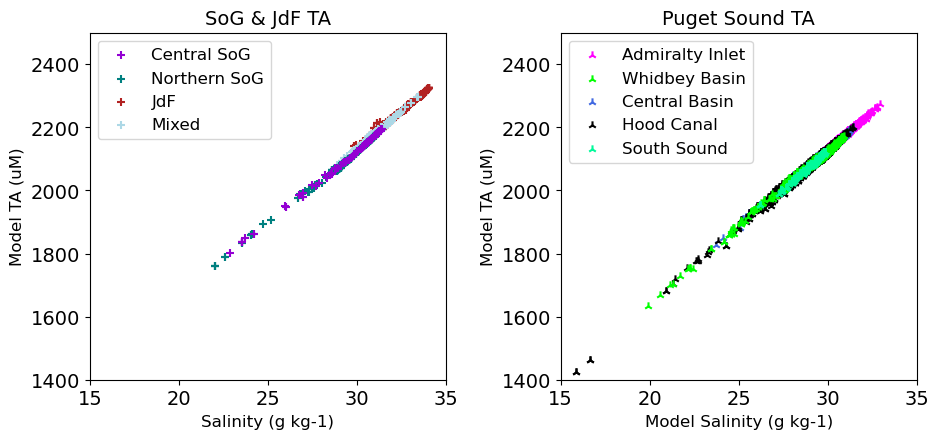

In [78]:
## TA
fig, ax = plt.subplots(1,2,figsize = (10,5))
fig.tight_layout(pad=3)
ax[0].scatter((CentralSoG['mod_vosaline']),(CentralSoG['mod_total_alkalinity']),color='darkviolet',label='Central SoG',marker='+',zorder=10)
ax[0].scatter((NorthernSoG['mod_vosaline']),(NorthernSoG['mod_total_alkalinity']),color='teal',label='Northern SoG',marker='+',zorder=8)
ax[0].scatter((JdF['mod_vosaline']),(JdF['mod_total_alkalinity']),color='firebrick',label='JdF',marker='+',zorder=2)
ax[0].scatter((Mixed['mod_vosaline']),(Mixed['mod_total_alkalinity']),color='lightblue',label='Mixed',marker='+',zorder=6)
ax[0].set_ylim(1400,2500)
ax[0].set_xlim(15,35)
#ax[0].plot((1400,2500),(1400,2500),'k-',alpha=.2)
ax[0].set_xlabel('Salinity (g kg-1)',fontsize=12)
ax[0].set_ylabel('Model TA (uM)',fontsize=12)
ax[0].set_title('SoG & JdF TA')
ax[0].legend(loc=2,fontsize=12)


#ax.scatter((Puget['DIC (uM)']),(Puget['mod_dissolved_inorganic_carbon']),label='Puget',marker='+',zorder=1)
ax[1].scatter((Admiralty['mod_vosaline']),(Admiralty['mod_total_alkalinity']),color='fuchsia',label='Admiralty Inlet',marker='2',zorder=1)
ax[1].scatter((Whidbey['mod_vosaline']),(Whidbey['mod_total_alkalinity']),color='lime',label='Whidbey Basin',marker='2',zorder=6)
ax[1].scatter((CentralBasin['mod_vosaline']),(CentralBasin['mod_total_alkalinity']),color='royalblue',label='Central Basin',marker='2',zorder=2)
ax[1].scatter((Hood['mod_vosaline']),(Hood['mod_total_alkalinity']),color='black',label='Hood Canal',marker='2',zorder=4)
ax[1].scatter((SouthSound['mod_vosaline']),(SouthSound['mod_total_alkalinity']),color='mediumspringgreen',label='South Sound',marker='2',zorder=10)

ax[1].set_ylim(1400,2500)
ax[1].set_xlim(15,35)
#ax[1].plot((1400,2500),(1400,2500),'k-',alpha=.2)
ax[1].set_xlabel('Model Salinity (g kg-1)',fontsize=12)
ax[1].set_ylabel('Model TA (uM)',fontsize=12)
ax[1].set_title('Puget Sound TA')
ax[1].legend(loc=2,fontsize=12)